# Building Synthetic Dataset


#### Before running our algorithm on the movielens dataset, we decided to build a synthetic dataset and see if our algorithim would at least perform reasonably well in theory.

#### It is important to note that, while the dimensions of the matricies involved in recommender systems are extremely large, their rank is usually comparetively small. This is  why matrix factorization using SVD is a viable option.

In [42]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from copy import deepcopy
from numpy.linalg import matrix_rank

d = 100
r = 10

def generate_data(rank):
  d=100
  data = np.zeros((100,100))
  r = rank
  while (matrix_rank(data) != rank):
    vec = (np.random.randint(9, size=(1,d))+1)/2
    mat = vec*np.transpose(vec)
    zer = np.zeros(mat.shape)

    for i in range(r-1):
      zer[i][i] = 1

    mat = mat + zer
    min_a = np.amin(mat)
    max_a = np.amax(mat)
    range_a = max_a - min_a

    data = 4.5*((mat - min_a)/range_a) + 0.5
    data = np.round(2*data)/2
    if (r < d):
      r += 1
  return data

data = generate_data(r)
u,m = data.shape
print("Rank:", matrix_rank(data))
print("Dataset Shape:", data.shape)
print(data)

Rank: 11
Dataset Shape: (100, 100)
[[0.5 1.  1.  ... 1.  0.5 0.5]
 [1.  3.5 3.5 ... 4.  1.  1. ]
 [1.  3.5 4.  ... 4.5 1.  1. ]
 ...
 [1.  4.  4.5 ... 5.  1.  1. ]
 [0.5 1.  1.  ... 1.  0.5 0.5]
 [0.5 1.  1.  ... 1.  0.5 0.5]]


In [39]:
from scipy.sparse.linalg import svds
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error as mae

densities = [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.05]
K = 50
final_MAE = np.zeros((K,len(densities)))
for k in range(K):
  MAE = []
  for i, density in enumerate(densities):
    train_select = np.random.choice(a=[False, True], size=(u,m), p=[1-density, density])
    test_select = np.logical_not(train_select)

    train = deepcopy(data)
    train[test_select] = np.nan

    test = deepcopy(data)
    test[train_select] = np.nan

    # print("Density:", density)
    # print((~np.isnan(train)).sum(), (~np.isnan(test)).sum())

    mean_rating = np.nanmean(train, axis=1)
    mm = np.nanmean(mean_rating, axis = 0)
    mnan = np.argwhere(np.isnan(mean_rating))
    mean_rating[mnan] = mm

    [m,u] = train.shape

    for i in range(m):
      for j in range(u):
        if(np.isnan(train[i,j])):
          train[i,j] = mean_rating[i]

    reconstruction = deepcopy(train)
    for j in range(20):
      U, sigma, Vt = svds(reconstruction, 20)
      sigma = np.diag(sigma)

      reconstruction = np.round(2*(np.dot(np.dot(U, sigma), Vt)))/2
      reconstruction[train_select] = train[train_select]

      reconstruction[reconstruction > 5] = 5
      reconstruction[reconstruction < 0.5] = 0.5

    reconstruction = np.round(2*(np.dot(np.dot(U, sigma), Vt)))/2
    result = reconstruction[test_select].flatten() 
    ground_truth = test[test_select].flatten()
    MAE.append(mae(result,ground_truth))
  final_MAE[k,:] = MAE


avg_MAE = np.mean(final_MAE, axis = 0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice


KeyboardInterrupt: ignored

Dataset Shape: (100, 100)
Dataset rank: 10
Minimum MAE: 0.26
Maximum MAE: 0.66


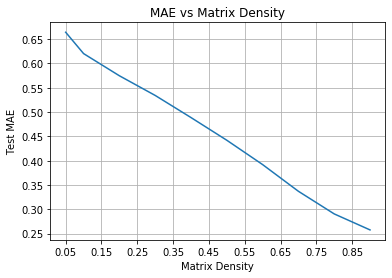

In [29]:
from matplotlib import pyplot as plt

plt.plot(densities, avg_MAE)
plt.xlabel('Matrix Density')
plt.ylabel('Test MAE')
plt.xticks(np.arange(min(densities), max(densities), 0.1))
plt.title("MAE vs Matrix Density")
plt.grid()

print("Dataset Shape:", data.shape)
print("Dataset rank:", matrix_rank(data))
print("Minimum MAE:", "{0:0.2f}".format(min(avg_MAE)))
print("Maximum MAE:", "{0:0.2f}".format(max(avg_MAE)))


In [117]:
required_ranks = list(range(10,40,2))

densities = [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.05]
K = 10
MAEs = []
MAEs = []
for r,rank in enumerate(required_ranks):
  data = generate_data(rank)
  print(matrix_rank(data))
  
  for i, density in enumerate(densities):
    for k in range(K):
      MAE = 0
      train_select = np.random.choice(a=[False, True], size=(u,m), p=[1-density, density])
      test_select = np.logical_not(train_select)

      train = deepcopy(data)
      train[test_select] = np.nan

      test = deepcopy(data)
      test[train_select] = np.nan

      mean_rating = np.nanmean(train, axis=1)
      mm = np.nanmean(mean_rating, axis = 0)
      mnan = np.argwhere(np.isnan(mean_rating))
      mean_rating[mnan] = mm

      [m,u] = train.shape

      for i in range(m):
        for j in range(u):
          if(np.isnan(train[i,j])):
            train[i,j] = mean_rating[i]

      reconstruction = deepcopy(train)
      for j in range(20):
        U, sigma, Vt = svds(reconstruction, 20)
        sigma = np.diag(sigma)

        reconstruction = np.round(2*(np.dot(np.dot(U, sigma), Vt)))/2
        reconstruction[train_select] = train[train_select]

        reconstruction[reconstruction > 5] = 5
        reconstruction[reconstruction < 0.5] = 0.5

      reconstruction = np.round(2*(np.dot(np.dot(U, sigma), Vt)))/2
      result = reconstruction[test_select].flatten() 
      ground_truth = test[test_select].flatten()
      MAE = MAE + mae(result,ground_truth)
    MAEs.append([rank,density,MAE/K])

MAEs = np.array(MAEs)

10


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice


12


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice


14


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice


16


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice


18


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice


20


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice


22


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice


24


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice


26


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice


28


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice


30


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice


32


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice


34


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice


36


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice


38


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice


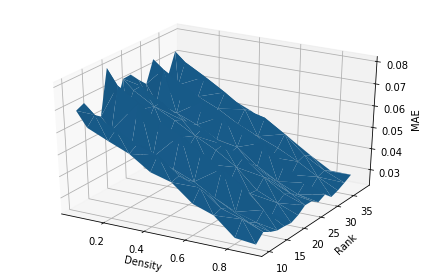

In [119]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
Axes3D.plot_trisurf(ax,MAEs[:,1],MAEs[:,0],MAEs[:,2])
ax.set_xlabel('Density')
ax.set_ylabel('Rank', rotation = 43)
ax.set_zlabel('MAE', rotation=90)

plt.tight_layout()

In [0]:
from scipy.sparse.linalg import svds
from sklearn.metrics import confusion_matrix

density = 0.2
data = generate_data(10)
train_select = np.random.choice(a=[False, True], size=(u,m), p=[1-density, density])
test_select = np.logical_not(train_select)

train = deepcopy(data)
train[test_select] = np.nan

test = deepcopy(data)
test[train_select] = np.nan

print("Density:", density)
print("Train Num Count:", (~np.isnan(train)).sum())
print("Test Num Count:", (~np.isnan(test)).sum())

mean_rating = np.round(2*np.nanmean(train, axis=0))/2
inds = np.where(np.isnan(train))
train[inds] = np.take(mean_rating, inds[1])

k = 2
tmax = 51
MAE = []
reconstruction = deepcopy(train)
for t in range(tmax):
  U, sigma, Vt = svds(reconstruction, k)
  sigma = np.diag(sigma)

  reconstruction = np.round(2*(np.dot(np.dot(U, sigma), Vt)))/2
  reconstruction[train_select] = train[train_select]

  reconstruction[reconstruction > 5] = 5
  reconstruction[reconstruction < 0.5] = 0.5

  result = reconstruction[test_select].flatten() 
  ground_truth = test[test_select].flatten()
  MAE.append(mae(result,ground_truth))


Density: 0.2
Train Num Count: 2026
Test Num Count: 7974


Dataset Shape: (100, 100)
Dataset rank: 11
Maximum MAE: 0.53
Minimum MAE: 0.26


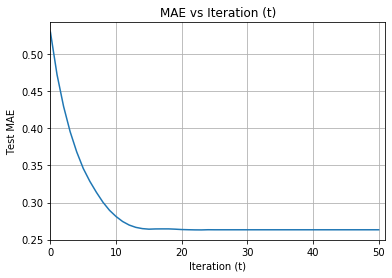

In [0]:
plt.plot(list(range(tmax)), MAE)
plt.xlabel('Iteration (t)')
plt.ylabel('Test MAE')
plt.xticks(np.arange(0, tmax, 10))
plt.xlim(0,tmax)
plt.title("MAE vs Iteration (t)")
plt.grid()

print("Dataset Shape:", data.shape)
print("Dataset rank:", matrix_rank(data))

print("Maximum MAE:", "{0:0.2f}".format(max(MAE)))
print("Minimum MAE:", "{0:0.2f}".format(min(MAE)))